# Real Estate Price Prediction Model

In [76]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import randint, uniform
import shap
import matplotlib.pyplot as plt

## 1. Data Loading and Initial Cleaning

In [77]:
df = pd.read_csv("scraped_data.csv")
df['official_pincode'] = df['official_pincode'].astype(str)

In [78]:
df.head(3)

,title,listing_url,status,transaction,furnishing,facing,bhk,locality,property_id,scraped_timestamp,price_in_lacs,total_floors,price_per_sqft,area_sqft_imputed,floor_number,latitude,longitude,official_pincode,dist_to_nearest_metro_km
0,"4 BHK Flat for Sale in Sector 107, Dadri Road...",https://www.magicbricks.com/propertyDetails/4-...,Ready to Move,New Property,Semi-Furnished,North - East,4,"Sector 107, Dadri Road, Noida",4d423737303639353531,2025-10-15T17:58:54.049268+00:00,440.0,21,88000.000000,500.0,10,28.547891,77.380094,201303,0.761710
1,"4 BHK Flat for Sale in Sector 115, Noida",https://www.magicbricks.com/propertyDetails/4-...,Unknown,Resale,Unfurnished,East,4,"Sector 115, Noida",4d423734393234333837,2025-10-15T17:58:54.057645+00:00,425.0,30,53191.489362,799.0,3,28.570540,77.322893,201313,0.309249
2,"3 BHK Flat for Sale in Sector 115, Noida",https://www.magicbricks.com/propertyDetails/3-...,Unknown,Resale,Unfurnished,North - East,3,"Sector 115, Noida",4d423733363731353533,2025-10-15T17:58:54.063499+00:00,310.0,29,101973.684211,304.0,6,28.570540,77.322893,201313,0.309249


<Axes: xlabel='price_in_lacs', ylabel='Density'>

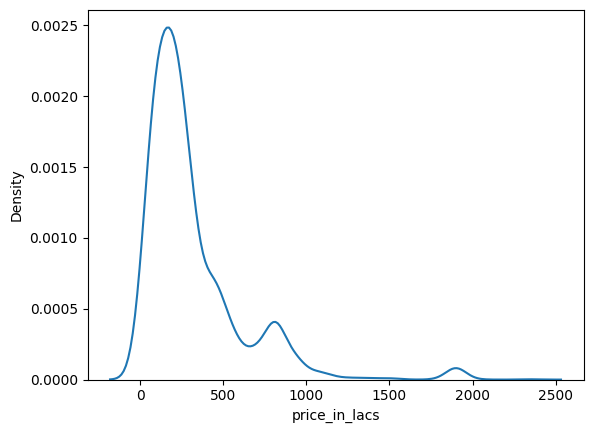

In [79]:
sns.kdeplot(df['price_in_lacs'])

## Feature Engineering

### Log Transformation of the Target Variable (because highly right-skewed)

In [80]:
TARGET_COLUMN = 'price_in_lacs'
df['log_price'] = np.log1p(df[TARGET_COLUMN])  ## log(1 + price_in_lakhs)
y = df['log_price']

<Axes: xlabel='log_price', ylabel='Density'>

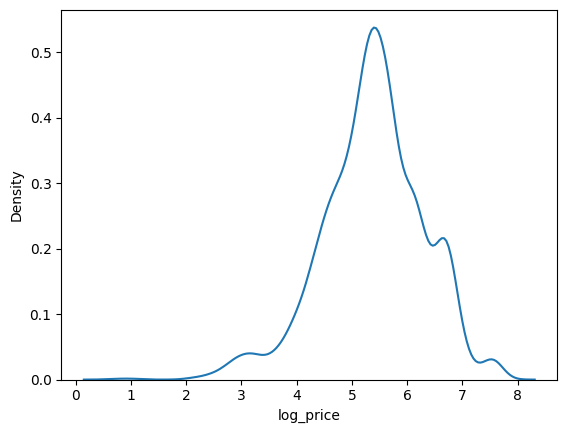

In [81]:
sns.kdeplot(df['log_price'])

### Creating New Columns (like relative floor to merge the total floors and floor number)

In [82]:
df['relative_floor'] = df['floor_number'] / df['total_floors']

### Interaction Features

In [83]:
# Interaction Feature that captures the combined value of a property's size and its proximity to the metro
df['location_premium'] = df['area_sqft_imputed'] / (df['dist_to_nearest_metro_km'] + 0.1)

# High count, Densely populated locality, all properties close to each other, predictable price
df['locality_count'] = df['locality'].map(df['locality'].value_counts())

### Target Encoding

In [84]:
# mapping of average price per locality, for each locality, we have one value of average price of all the properties in that locality
locality_map = df.groupby('locality')['log_price'].mean()

# mapping of average price per pincode
pincode_map = df.groupby('official_pincode')['log_price'].mean()

# mapping the mean log_price back to the dataframe

# ------------------------------------------------------------------------------------------------------------------------
# This feature is basically telling - "This property is in an area where the average price is 'X' , similarly for pincode
# ------------------------------------------------------------------------------------------------------------------------

df['locality_price_encoded'] = df['locality'].map(locality_map)
df['pincode_price_encoded'] = df['official_pincode'].map(pincode_map)

## 3. Model Selection and Tuning

In [85]:
# --- Feature Selection and Data Split ---
X = df.drop(columns=[
    TARGET_COLUMN, 'log_price', 'title', 'listing_url',
    'property_id', 'scraped_timestamp', 'price_per_sqft',
    'locality',  # dropping original locality
    'official_pincode' # dropping original pincode
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Numerical and Categorical Columns

In [86]:
# The new encoded features are now NUMERICAL
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [87]:
numerical_features

['bhk',
 'total_floors',
 'area_sqft_imputed',
 'floor_number',
 'latitude',
 'longitude',
 'dist_to_nearest_metro_km',
 'relative_floor',
 'location_premium',
 'locality_count',
 'locality_price_encoded',
 'pincode_price_encoded']

In [88]:
categorical_features

['status', 'transaction', 'furnishing', 'facing']

### Pipeline Setup

In [89]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# OHE only for the low-cardinality features (status, facing, furnishing, etc.)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

### Random Forest Model and Tuning

In [90]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Define parameter grid for tuning Random Forest
param_grid = {
    'regressor__n_estimators': randint(200, 1000),
    'regressor__max_depth': randint(10, 30),
    'regressor__min_samples_split': randint(2, 10),     # Min samples to split an internal node
    'regressor__min_samples_leaf': randint(1, 5),       # Min samples in a leaf node
}

# Randomized Search: 20 iterations (100 total fits)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [91]:
# --- Train and Predict ---

print("--- Random Forest Randomized Search Tuning ---")
random_search.fit(X_train, y_train)
print("--- Tuning Complete ---")

--- Random Forest Randomized Search Tuning ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
--- Tuning Complete ---


In [92]:
# the best estimator
best_model = random_search.best_estimator_

# predicting on the test set
y_pred_log = best_model.predict(X_test) # y_pred_log is the predicted log-transformed price (log_price) for each property in the test set.

# Inverse Transformation for the predictions and the actual values ro convert back into lakhs scale for evaluation
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_log)

## Final Model Evaluation and Results

In [93]:
# --- Evaluating Test Metrics ---
r2 = r2_score(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))


#  Applying Cross-Validation Score on the Best Model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

print("\n==============================================")
print("  FINAL MODEL EVALUATION (Tuned Random Forest)  ")
print("==============================================")
print(f"Best RF Parameters: {random_search.best_params_}")
print("----------------------------------------------")
print(f"R-squared (R²) on Test Data:  {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} Lacs")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Lacs")
print("----------------------------------------------")
print(f"Mean CV R-squared (R²):   {cv_scores.mean():.4f}")
print(f"CV R-squared Std. Dev.:   {cv_scores.std():.4f}")
print("==============================================")


  FINAL MODEL EVALUATION (Tuned Random Forest)  
Best RF Parameters: {'regressor__max_depth': 25, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 7, 'regressor__n_estimators': 886}
----------------------------------------------
R-squared (R²) on Test Data:  0.8617
Mean Absolute Error (MAE): 49.51 Lacs
Root Mean Squared Error (RMSE): 115.85 Lacs
----------------------------------------------
Mean CV R-squared (R²):   0.8267
CV R-squared Std. Dev.:   0.0293


# SHAP Plots Explaining Feature Importance



--- SHAP Summary Plot (Feature Importance & Direction) ---


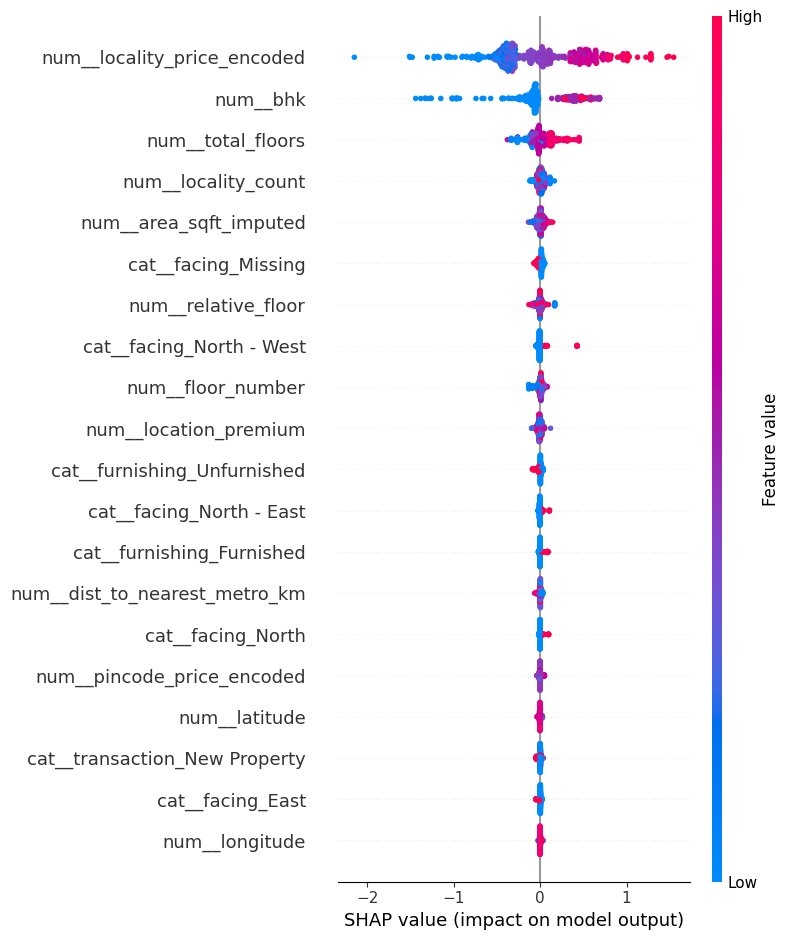

In [94]:
# plotting shap values for the processed features
X_train_processed = best_model.named_steps['preprocessor'].transform(X_train)
X_train_processed_df = pd.DataFrame(
    X_train_processed,
    columns=best_model.named_steps['preprocessor'].get_feature_names_out()
)

regressor = best_model.named_steps['regressor']

# Initializing the SHAP Explainer for Tree Models
explainer = shap.TreeExplainer(regressor)

# Calculating SHAP values for the processed data
# a small subset for faster plotting, e.g., 500 rows
sample_size = min(500, X_train_processed_df.shape[0])
sample_data = X_train_processed_df.sample(sample_size, random_state=42)
shap_values = explainer.shap_values(sample_data)

print("\n\n--- SHAP Summary Plot (Feature Importance & Direction) ---")

# Generating SHAP Summary Plot
shap.summary_plot(shap_values, sample_data, show=False)
plt.tight_layout()
plt.show()

Color → Feature Value (High/Low)

Pink/Red = high feature value

Blue = low feature value

Positive SHAP values (right side) → Feature increases predicted price.

Negative SHAP values (left side) → Feature decreases predicted price.

for instance:

For num__locality_price_encoded, red points are on the right → high locality price strongly increases prediction.

For num__bhk, red points (more bedrooms) are mostly right-shifted → higher BHK → higher predicted price.

For num__total_floors, moderate right-shift shows buildings with more floors tend to correlate with higher prices (e.g., premium apartments).

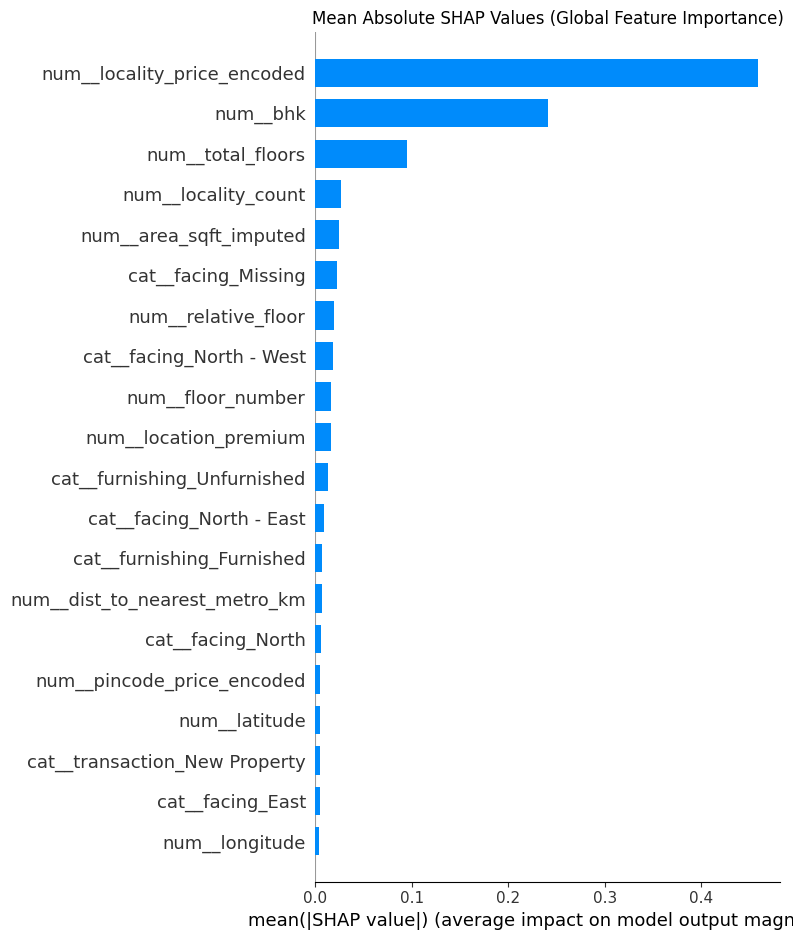

In [95]:
shap.summary_plot(shap_values, sample_data, plot_type="bar", show=False)
plt.title("Mean Absolute SHAP Values (Global Feature Importance)")
plt.tight_layout()
plt.show()

In [96]:
shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": sample_data.columns,
    "Mean |SHAP|": shap_importance
}).sort_values("Mean |SHAP|", ascending=False)

print("\nTop 10 Most Influential Features:")
print(importance_df.head(10))


Top 10 Most Influential Features:
                        Feature  Mean |SHAP|
10  num__locality_price_encoded     0.458956
0                      num__bhk     0.241438
1             num__total_floors     0.095233
9           num__locality_count     0.025977
2        num__area_sqft_imputed     0.024193
21          cat__facing_Missing     0.022249
7           num__relative_floor     0.019420
24     cat__facing_North - West     0.017841
3             num__floor_number     0.015960
8         num__location_premium     0.015827
